## CNN VAE to regenerate MNIST images from noise

In [88]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [94]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [91]:
data = pd.read_csv('mnist_train.csv')
data = np.array(data)

data = data[0:10000,:] # Extracting first 10000 samples
data.shape

# Data without labels because Unsupervised learning
data = data[:,1:]

# Data Normalization
dataN = data / np.max(data)

# Converting to pytorch tensor
dataT = torch.tensor( dataN, dtype = torch.float32)
dataT = dataT.reshape(dataT.shape[0], 1, 28, 28)

In [92]:
#Create VAE
class VAE(nn.Module):
    def __init__(self):
        super(VAE,self).__init__()

        # Encoder Layers

        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.linear1 = nn.Linear(512,300)
        self.mu = nn.Linear(300, 16) # latent_size = 16
        self.logvar = nn.Linear(300, 16)



        # Decoder Layers

        self.linear2 = nn.Linear(16, 300)
        self.linear3 = nn.Linear(300, 512)
        self.conv3 = nn.ConvTranspose2d(32, 16, kernel_size=5,stride=2)
        self.conv4 = nn.ConvTranspose2d(16, 1, kernel_size=5, stride=2)
        self.conv5 = nn.ConvTranspose2d(1, 1, kernel_size=4)



    def encoder(self,x):
        t = F.relu(self.conv1(x))
        t = F.relu(self.conv2(t))
        t = t.reshape((x.shape[0], -1))

        t = F.relu(self.linear1(t))
        mu = self.mu(t)
        logvar = self.logvar(t)
        return mu, logvar

    def reparameterization(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std).to(device)
        return eps*std + mu

    def unFlatten(self, x):
        return x.reshape((x.shape[0], 32, 4, 4))

    def decoder(self, z):
        t = F.relu(self.linear2(z))
        t = F.relu(self.linear3(t))
        t = self.unFlatten(t)
        t = F.relu(self.conv3(t))
        t = F.relu(self.conv4(t))
        t = torch.sigmoid(self.conv5(t))
        return t


    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterization(mu,logvar)
        pred = self.decoder(z)
        return pred, mu, logvar

In [93]:
#Create loss function

def loss_func(reconstructed_image, original_image, mu, logvar):
    BCE = F.binary_cross_entropy(reconstructed_image, original_image, reduction = 'sum') # BCE Loss for image reconstruction
    DKL = -0.5 * torch.sum(-logvar.exp() - mu.pow(2) + 1 + logvar) # kld loss for reduccing similarities b/w distributions.
    return BCE + DKL # sum of all the losses


# We are using BCE loss since our target or original image is normalized between 0 and 1.
# reduction = 'sum' means we want to sum the output loss.

In [95]:
#Instance and optimiser
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

In [96]:
#Train
epochs = 21001

losses = torch.zeros(epochs)

for epoch in range(epochs):

  # Selecting a batchsize  of 32.

  random_idx = np.random.choice(dataT.shape[0], size=32)

  X = dataT[random_idx,:].to(device)
  predicted, mu, logvar = model(X)
  loss = loss_func(predicted, X, mu, logvar)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  losses[epoch] = loss.item()

  if (epoch % 1000) == 0:

      print(f' epochs : {epoch}  loss : {loss}')

 epochs : 0  loss : 19212.04296875
 epochs : 1000  loss : 5142.78271484375
 epochs : 2000  loss : 4195.46142578125
 epochs : 3000  loss : 3814.865234375
 epochs : 4000  loss : 4021.564208984375
 epochs : 5000  loss : 3888.12646484375
 epochs : 6000  loss : 3688.41943359375
 epochs : 7000  loss : 3800.62841796875
 epochs : 8000  loss : 3618.562255859375
 epochs : 9000  loss : 3452.050537109375
 epochs : 10000  loss : 3508.16650390625
 epochs : 11000  loss : 3432.81396484375
 epochs : 12000  loss : 3345.38427734375
 epochs : 13000  loss : 3245.10693359375
 epochs : 14000  loss : 3514.138671875
 epochs : 15000  loss : 3497.4951171875
 epochs : 16000  loss : 3282.048828125
 epochs : 17000  loss : 3463.288330078125
 epochs : 18000  loss : 3531.403564453125
 epochs : 19000  loss : 3415.943115234375
 epochs : 20000  loss : 3496.95947265625
 epochs : 21000  loss : 3280.74365234375


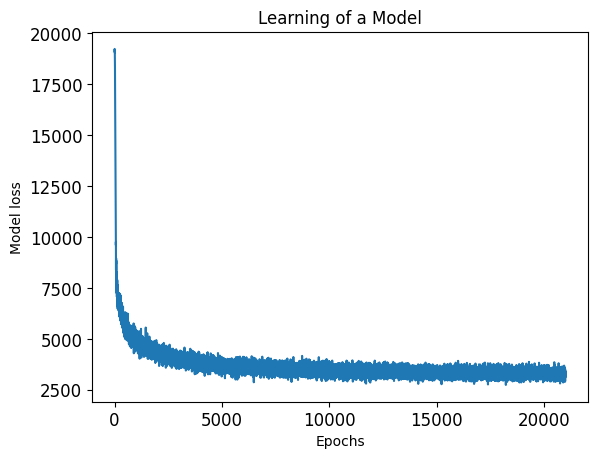

In [97]:
#Loss Vis
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.title('Learning of a Model')
plt.show()

In [98]:
#Testing
X = dataT[:7,:].to(device)  # Extracting first seven samples
ypred, mu, logvar = model(X)

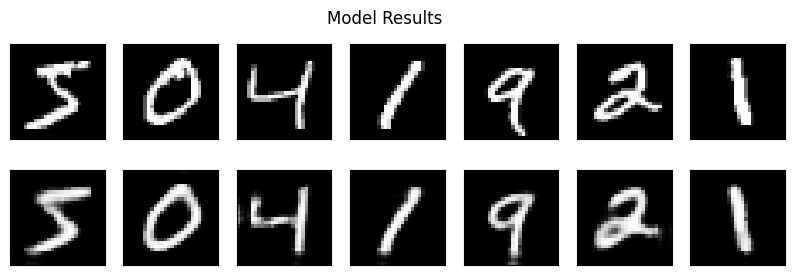

In [99]:
fig,axes = plt.subplots(2,7,figsize=(10,3))

for i in range(7):
  axes[0,i].imshow(X[i,:].view(28,28).detach().cpu() ,cmap='gray')
  axes[1,i].imshow(ypred[i,:].view(28,28).detach().cpu() ,cmap='gray')
  axes[0,i].set_xticks([]), axes[0,i].set_yticks([])
  axes[1,i].set_xticks([]), axes[1,i].set_yticks([])

plt.suptitle('Model Results')
plt.show()

In [105]:
# Generating 7 samples from Gaussian Distribution of size equal to latent layer size i.e 16
sample = torch.randn(7,16)

#Pass the samples to decoder
y_pred = model.decoder(sample.to(device))


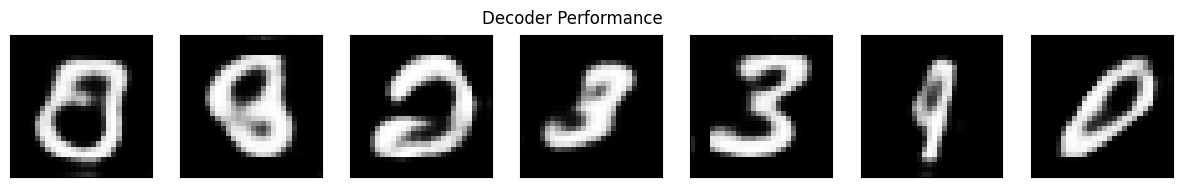

In [106]:
# Visualize the decoder performance on randomly generated samples
fig,axes = plt.subplots(1,7,figsize=(15,2))

for i in range(7):
  axes[i].imshow(y_pred[i,:].view(28,28).detach().cpu() ,cmap='gray')
  axes[i].set_xticks([]), axes[i].set_yticks([])
  axes[i].set_xticks([]), axes[i].set_yticks([])

plt.suptitle('Decoder Performance')
plt.show()